<a href="https://colab.research.google.com/github/AntoineDps/Courses/blob/main/Exercise_8_2_cosmic_ray_identification_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 8.2 - Solution
Large arrays of radio antennas can be used to measure cosmic rays by recording the electromagnetic radiation generated in the atmosphere.
These radio signals are strongly contaminated by galactic noise as well as signals from human origin. Since these signals appear to be similar to the background, the discovery of cosmic-ray events can be challenging.
## Identification of signals
In this exercise, we design an RNN to classify if the recorded radio signals contain a cosmic-ray event or only noise.

The signal-to-noise ratio (SNR) of a measured trace $S(t)$ is defined as follows:

$$\mathrm{SNR}=\frac{S^{\mathrm{signal}}(t)_\mathrm{max}}{\mathrm{RMS}[S(t)]},$$  
where $S^{\mathrm{signal}}(t)_\mathrm{max}$ denotes the maximum amplitude of the (true) signal.

Typical cosmic-ray observatories enable a precise reconstruction at an SNR of roughly 3.

We choose a challenging setup in this task and try to identify cosmic-ray events in signal traces with an SNR of 2.  
Training RNNs can be computationally demanding, thus, we recommend to use a GPU for this task.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

layers = keras.layers
print("keras", keras.__version__)

keras 2.7.0


### Load and prepare dataset
In this task, we use a simulation of cosmic-ray-induced air showers that are measured by radion antennas.  
For more information, see https://arxiv.org/abs/1901.04079.  
The task is to design an RNN which is able to identify if the measured signal traces (shortened to 500 time steps) contains a signal or not.

In [ ]:
import os
import gdown
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1R-qfxO1jVh88TC9Gnm9JGMomSRg0Zpkx"
output = 'radio_data.npz'

if os.path.exists(output) == False:
    gdown.download(url, output, quiet=True)

f = np.load(output) # we have 50000 events in total
n_train = 40000 # let's use 40000 for training and validation, the rest we use for testing. 
print(list(f.keys()))
print(f['traces'].shape)
print(f['signals'].shape)
x_train, x_test = f["traces"][:n_train], f["traces"][n_train:]  # measured traces (signal + noise), or only noise

signals = f["signals"]  # signal part (only available for cosmic-ray events)
# if the even is noise, the signal trace is consists of zeros. 
# so we can find out if an event is signal or noise by selecting the events
# that have non-zero entries in the signal arrays. 
labels = (signals.std(axis=-1) != 0).astype(float)  # define training label (1=cosmic event, 0=noise)
# split up the labels into training and test data set
y_train, y_test = labels[:n_train], labels[n_train:]

['traces', 'signals']
(50000, 500)
(50000, 500)


## Plot example signal traces
Left: signal trace containing a cosmic-ray event. The underlying cosmic-ray signal is shown in red, the backgrounds + signal is shown in blue.
Right: background noise.

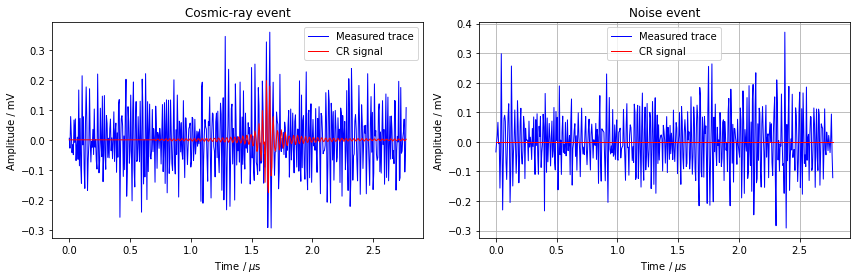

In [ ]:
from matplotlib import pyplot as plt
# these two lines calculate the time values for each bin.
fs = 180e6  # Sampling frequency of antenna setup 180 MHz
t = np.arange(500) / fs * 1e6

i_signal_event = 19
i_noise_event = 21

plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
# first plot a signal event
# f["traces"][labels.astype(bool)] selects all signal traces
plt.plot(t, f["traces"][labels.astype(bool)][i_signal_event], linewidth = 1, color="b", label="Measured trace")
plt.plot(t, signals[labels.astype(bool)][i_signal_event], linewidth = 1, color="r", label="CR signal")
plt.ylabel('Amplitude / mV')
plt.xlabel('Time / $\mu \mathrm{s}$')
plt.legend()
plt.title("Cosmic-ray event")
plt.subplot(1, 2, 2)

# now plot a noise event
plt.plot(t, f["traces"][~labels.astype(bool)][i_noise_event], linewidth = 1, color="b", label="Measured trace")
plt.plot(t, signals[~labels.astype(bool)][i_signal_event], linewidth = 1, color="r", label="CR signal") # we see that the signal is always zero because we plot a noise event. 
plt.ylabel('Amplitude / mV')
plt.xlabel('Time / $\mu \mathrm{s}$')
plt.legend()
plt.title("Noise event")

plt.grid(True)
plt.tight_layout()

In [ ]:
sigma = x_train.std()
x_train /= sigma
x_test /= sigma

### Define RNN model
In the following, design a cosmic-ray model to identify cosmic-ray events using an RNN-based classifier.

In [ ]:
model = keras.models.Sequential()
# because the network architecture includes a dense layer at the end, we need to specify the input shape, i.e., 
# the length of the input array is not arbitrary. 
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True), input_shape=(500,1)))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(10, return_sequences=True)))

# it is a classification task: Noise or Signal. 
# for a binary classification task, we can use a single output node with a 
# sigmoid activation. 
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 500, 64)           8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 128)          66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500, 20)           11120     
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 95,873
Trainable params: 95,873
Non-trainable params: 0
____________________________________________________

#### Pre-processing of data and RNN training

The training might take a long time. Either adjust the number of epochs, or just cancel the computation at some point. The `model` object will still contain the latest version of the network. 

In [ ]:
model.compile(
    loss='binary_crossentropy',  # for a binary classification task, use `binary_crossentropy`
    optimizer=keras.optimizers.Adam(1e-3, decay=0.00008),
    metrics=['accuracy'])


results = model.fit(x_train[...,np.newaxis], y_train,
                    batch_size=128,
                    epochs=100, 
                    verbose=1,
                    validation_split=0.1,
                    callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1, min_lr=1e-5),
                                 keras.callbacks.EarlyStopping(patience=15, verbose=1)]
                    )

Epoch 1/100
282/282 [==============================] - 178s 579ms/step - loss: 0.6369 - accuracy: 0.6368 - val_loss: 0.5869 - val_accuracy: 0.6812
Epoch 2/100
282/282 [==============================] - 169s 600ms/step - loss: 0.5908 - accuracy: 0.6808 - val_loss: 0.5910 - val_accuracy: 0.6790
Epoch 3/100
282/282 [==============================] - 170s 603ms/step - loss: 0.5882 - accuracy: 0.6840 - val_loss: 0.5820 - val_accuracy: 0.6883
Epoch 4/100
282/282 [==============================] - 170s 603ms/step - loss: 0.5861 - accuracy: 0.6837 - val_loss: 0.5974 - val_accuracy: 0.6798
Epoch 5/100
282/282 [==============================] - 169s 601ms/step - loss: 0.5847 - accuracy: 0.6844 - val_loss: 0.5830 - val_accuracy: 0.6800
Epoch 6/100
282/282 [==============================] - 163s 579ms/step - loss: 0.5853 - accuracy: 0.6843 - val_loss: 0.5809 - val_accuracy: 0.6845
Epoch 7/100
282/282 [==============================] - 161s 572ms/step - loss: 0.5825 - accuracy: 0.6879 - val_loss: 0

In [ ]:
model.evaluate(x_test[...,np.newaxis], y_test)

313/313 [==============================] - 85s 272ms/step - loss: 0.0262 - accuracy: 0.9924


[0.026206644251942635, 0.9923999905586243]

In [ ]:
y_pred_test = model.predict(x_test[0:1, ..., np.newaxis])

In [ ]:
print(x_test[0:1, ..., np.newaxis].shape)
print(y_pred_test.shape)
print(y_pred_test)

(1, 500, 1)
(1, 1)
[[0.99999976]]


### Plot loss and accuracy

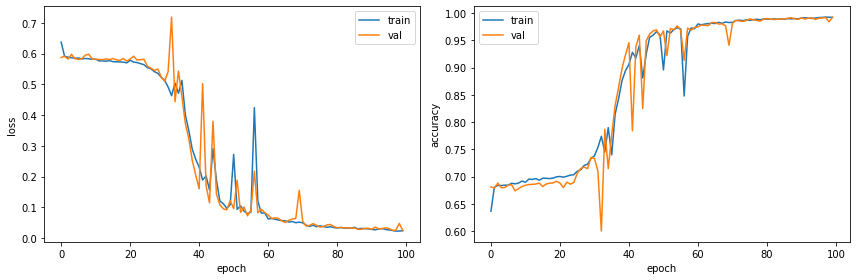

In [ ]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()

The code below implements a much smaller network which is not capable of obtaining a good accuracty

In [ ]:
model2 = keras.models.Sequential()
model2.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True), input_shape=(500,1)))

# it is a classification task: Noise or Signal. 
# for a binary classification task, we can use a single output node with a 
# sigmoid activation. 
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(1, activation="sigmoid"))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 500, 64)           8704      
_________________________________________________________________
flatten_3 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 32001     
Total params: 40,705
Trainable params: 40,705
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(
    loss='binary_crossentropy',  # for a binary classification task, use `binary_crossentropy`
    optimizer=keras.optimizers.Adam(1e-3, decay=0.00008),
    metrics=['accuracy'])


results2 = model2.fit(x_train[...,np.newaxis], y_train,
                    batch_size=128,
                    epochs=100, 
                    verbose=1,
                    validation_split=0.1,
                    callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1, min_lr=1e-5),
                                 keras.callbacks.EarlyStopping(patience=15, verbose=1)]
                    )

Epoch 1/100
282/282 [==============================] - 54s 179ms/step - loss: 0.6337 - accuracy: 0.6313 - val_loss: 0.6049 - val_accuracy: 0.6640
Epoch 2/100
282/282 [==============================] - 49s 175ms/step - loss: 0.6039 - accuracy: 0.6710 - val_loss: 0.5909 - val_accuracy: 0.6737
Epoch 3/100
282/282 [==============================] - 49s 175ms/step - loss: 0.5880 - accuracy: 0.6817 - val_loss: 0.5872 - val_accuracy: 0.6840
Epoch 4/100
282/282 [==============================] - 50s 176ms/step - loss: 0.5851 - accuracy: 0.6851 - val_loss: 0.6025 - val_accuracy: 0.6665
Epoch 5/100
282/282 [==============================] - 49s 174ms/step - loss: 0.5857 - accuracy: 0.6826 - val_loss: 0.5885 - val_accuracy: 0.6773
Epoch 6/100
282/282 [==============================] - 49s 173ms/step - loss: 0.5812 - accuracy: 0.6881 - val_loss: 0.5834 - val_accuracy: 0.6858
Epoch 7/100
282/282 [==============================] - 49s 174ms/step - loss: 0.5832 - accuracy: 0.6864 - val_loss: 0.5847 -